In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import logging
from typing import Tuple, List, Dict, Optional
import warnings

warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(level=logging.INFO)

# For offline mode simulation
np.random.seed(42)

In [2]:
# Cell 2: Initialize Microscope
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from autoscript_tem_microscope_client import TemMicroscopeClient

# Choose your mode
OFFLINE_MODE = True  # Set to False for real microscope operation

if OFFLINE_MODE:
    # Offline simulation mode
    print("Running in OFFLINE simulation mode")
    microscope = None
    acquisition = None  # TFacquisition(microscope, offline=True)
else:
    # Real microscope operation
    print("Connecting to real microscope...")
    microscope = TemMicroscopeClient()
    microscope.connect("localhost")  # Adjust IP as needed
    acquisition = TFacquisition(microscope, offline=False)

print("Microscope initialized successfully!")

Running in OFFLINE simulation mode
Microscope initialized successfully!


In [3]:
# Cell 3: Simulation Functions for Offline Mode
def simulate_haadf_image(size: int = 512) -> np.ndarray:
    """Simulate a HAADF image with various features"""
    # Create base noise
    image = np.random.normal(0, 0.1, (size, size))

    # Add some circular features (nanoparticles)
    for _ in range(10):
        x, y = np.random.randint(50, size - 50, 2)
        radius = np.random.randint(10, 30)
        intensity = np.random.uniform(0.5, 2.0)

        yy, xx = np.ogrid[:size, :size]
        mask = (xx - x) ** 2 + (yy - y) ** 2 <= radius**2
        image[mask] += intensity

    # Add some linear features
    for _ in range(5):
        x1, y1 = np.random.randint(0, size, 2)
        x2, y2 = np.random.randint(0, size, 2)
        thickness = np.random.randint(2, 8)
        intensity = np.random.uniform(0.3, 1.0)

        # Simple line drawing
        length = int(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))
        if length > 0:
            xs = np.linspace(x1, x2, length).astype(int)
            ys = np.linspace(y1, y2, length).astype(int)
            for i in range(-thickness // 2, thickness // 2):
                for j in range(-thickness // 2, thickness // 2):
                    valid_x = np.clip(xs + i, 0, size - 1)
                    valid_y = np.clip(ys + j, 0, size - 1)
                    image[valid_y, valid_x] += intensity

    # Normalize to 0-255
    image = (image - image.min()) / (image.max() - image.min())
    return (image * 255).astype(np.uint8)


def simulate_cbed_pattern(patch: np.ndarray) -> np.ndarray:
    """Simulate CBED pattern based on patch characteristics"""
    # Extract features from patch
    mean_intensity = np.mean(patch)
    std_intensity = np.std(patch)

    # Create base diffraction pattern (256x256)
    cbed = np.zeros((256, 256))
    center = 128

    # Central beam
    y, x = np.ogrid[:256, :256]
    central_mask = (x - center) ** 2 + (y - center) ** 2 <= 25
    cbed[central_mask] = 1000 * (1 + mean_intensity / 255.0)

    # Add diffraction spots based on patch characteristics
    num_spots = int(10 * (std_intensity / 50.0))  # More spots for higher variance
    for i in range(num_spots):
        angle = np.random.uniform(0, 2 * np.pi)
        distance = np.random.uniform(40, 100)
        spot_x = int(center + distance * np.cos(angle))
        spot_y = int(center + distance * np.sin(angle))

        if 10 < spot_x < 246 and 10 < spot_y < 246:
            intensity = np.random.uniform(50, 200) * (mean_intensity / 255.0)
            spot_mask = (x - spot_x) ** 2 + (y - spot_y) ** 2 <= 9
            cbed[spot_mask] += intensity

    # Add noise
    cbed += np.random.normal(0, 10, cbed.shape)
    cbed = np.maximum(cbed, 0)  # No negative intensities

    return cbed.astype(np.float32)


def extract_scalar_from_cbed(cbed: np.ndarray) -> float:
    """Extract a scalar property from CBED pattern"""
    # This could represent crystallinity, strain, or other structural property
    # Using a combination of features

    # Feature 1: Intensity ratio (spots vs background)
    center_region = cbed[108:148, 108:148]  # Central 40x40 region
    outer_region = cbed[50:206, 50:206]  # Outer region
    outer_region = outer_region[
        ~np.isin(np.arange(156 * 156), np.arange(58 * 58) + 49 * 156 + 49).reshape(
            156, 156
        )
    ]

    intensity_ratio = np.mean(center_region) / (np.mean(outer_region) + 1e-6)

    # Feature 2: Symmetry measure
    flipped_cbed = np.fliplr(cbed)
    symmetry = 1.0 / (1.0 + np.mean((cbed - flipped_cbed) ** 2))

    # Feature 3: High frequency content
    fft_cbed = np.fft.fft2(cbed)
    high_freq = np.sum(np.abs(fft_cbed[64:192, 64:192])) / np.sum(np.abs(fft_cbed))

    # Combine features into a single scalar (representing some material property)
    scalar_property = 0.4 * intensity_ratio + 0.3 * symmetry + 0.3 * high_freq

    return float(scalar_property)


print("Simulation functions defined!")

Simulation functions defined!


In [4]:
# Cell 4: Active Learning Class Implementation
class ActiveLearningSTEM:
    def __init__(
        self, acquisition_system, patch_size: int = 64, n_pca_components: int = 10
    ):
        self.acquisition = acquisition_system
        self.patch_size = patch_size
        self.n_pca_components = n_pca_components

        # Initialize PCA and scaler
        self.pca = PCA(n_components=n_pca_components)
        self.scaler = StandardScaler()

        # Initialize Gaussian Process
        kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
        self.gp = GaussianProcessRegressor(
            kernel=kernel, alpha=1e-6, normalize_y=True, random_state=42
        )

        # Storage for data
        self.patches = []
        self.patch_coordinates = []
        self.cbed_patterns = []
        self.scalar_properties = []
        self.pca_features = None

        print(
            f"Active Learning system initialized with patch size {patch_size}x{patch_size}"
        )

    def get_haadf_image(self) -> np.ndarray:
        """Acquire HAADF image"""
        if OFFLINE_MODE:
            return simulate_haadf_image(512)
        else:
            image_data, _ = self.acquisition.acquire_haadf(
                exposure=40e-9, resolution=512
            )
            return image_data

    def extract_patches(
        self, image: np.ndarray, stride: Optional[int] = None
    ) -> List[Dict]:
        """Extract patches from HAADF image"""
        if stride is None:
            stride = self.patch_size // 2

        patches_info = []
        h, w = image.shape

        for y in range(0, h - self.patch_size + 1, stride):
            for x in range(0, w - self.patch_size + 1, stride):
                patch = image[y : y + self.patch_size, x : x + self.patch_size]

                patches_info.append(
                    {
                        "patch": patch,
                        "coordinates": (
                            x + self.patch_size // 2,
                            y + self.patch_size // 2,
                        ),
                        "index": len(patches_info),
                    }
                )

        print(f"Extracted {len(patches_info)} patches from image")
        return patches_info

    def get_cbed_pattern(self, coordinates: Tuple[int, int]) -> np.ndarray:
        """Acquire CBED pattern at given coordinates"""
        if OFFLINE_MODE:
            # Get the patch at these coordinates for simulation
            patch_idx = None
            for i, coord in enumerate(self.patch_coordinates):
                if coord == coordinates:
                    patch_idx = i
                    break

            if patch_idx is not None and patch_idx < len(self.patches):
                return simulate_cbed_pattern(self.patches[patch_idx])
            else:
                # Create dummy patch for simulation
                dummy_patch = np.random.randint(
                    0, 255, (self.patch_size, self.patch_size)
                )
                return simulate_cbed_pattern(dummy_patch)
        else:
            # Real microscope operation
            # Move beam to coordinates and acquire CBED
            x_norm = coordinates[0] / 512.0
            y_norm = coordinates[1] / 512.0
            self.acquisition.move_paused_beam(x_norm, y_norm)
            cbed_data, _ = self.acquisition.acquire_ceta_or_flucam(
                exposure=0.1, resolution=256, camera="ceta"
            )
            return cbed_data

    def compute_pca_features(self, patches: List[np.ndarray]) -> np.ndarray:
        """Compute PCA features for patches"""
        # Flatten patches
        flattened_patches = np.array([patch.flatten() for patch in patches])

        # Scale features
        scaled_patches = self.scaler.fit_transform(flattened_patches)

        # Apply PCA
        pca_features = self.pca.fit_transform(scaled_patches)

        print(f"PCA explained variance ratio: {self.pca.explained_variance_ratio_}")
        print(
            f"Total explained variance: {np.sum(self.pca.explained_variance_ratio_):.3f}"
        )

        return pca_features

    def acquisition_function(
        self, X_train: np.ndarray, X_candidates: np.ndarray
    ) -> np.ndarray:
        """Upper Confidence Bound acquisition function"""
        if len(X_train) == 0:
            # Random selection for first point
            return np.random.random(len(X_candidates))

        # Predict mean and variance
        mean, std = self.gp.predict(X_candidates, return_std=True)

        # UCB with beta=2
        ucb = mean + 2.0 * std

        return ucb

    def select_next_measurement(
        self, candidate_features: np.ndarray, measured_indices: List[int]
    ) -> int:
        """Select next measurement location using acquisition function"""
        if not measured_indices:
            # Random first selection
            return np.random.randint(len(candidate_features))

        # Get unmeasured candidates
        unmeasured_indices = [
            i for i in range(len(candidate_features)) if i not in measured_indices
        ]

        if not unmeasured_indices:
            return None

        # Compute acquisition function values
        measured_features = candidate_features[measured_indices]
        candidate_features_unmeasured = candidate_features[unmeasured_indices]

        acquisition_values = self.acquisition_function(
            measured_features, candidate_features_unmeasured
        )

        # Select best candidate
        best_candidate_idx = np.argmax(acquisition_values)
        return unmeasured_indices[best_candidate_idx]

    def train_gp_model(self, X: np.ndarray, y: np.ndarray):
        """Train Gaussian Process model"""
        self.gp.fit(X, y)
        score = self.gp.score(X, y)
        print(f"GP model trained. R² score: {score:.3f}")

    def predict_properties(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Predict properties using trained GP model"""
        return self.gp.predict(X, return_std=True)


print("Active Learning class defined!")

Active Learning class defined!


Active Learning system initialized with patch size 64x64
Step 1: Acquiring HAADF image...


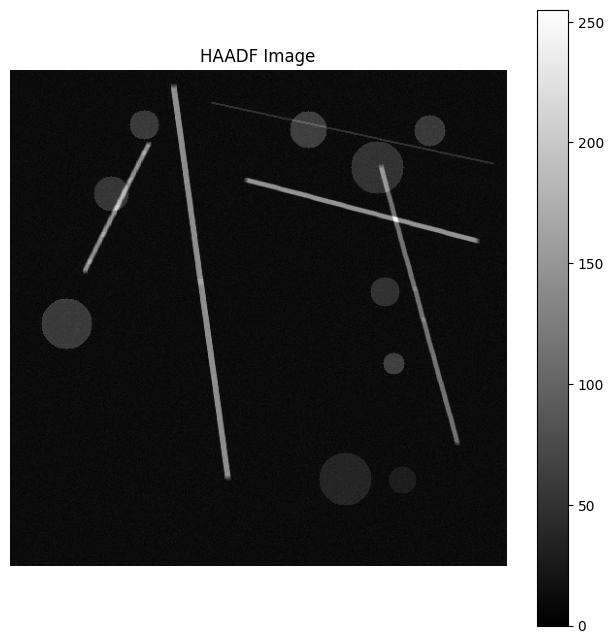

HAADF image acquired with shape: (512, 512)


In [5]:
# Cell 5: Initialize Active Learning System and Acquire Initial Data
# Initialize the active learning system
al_system = ActiveLearningSTEM(acquisition, patch_size=64, n_pca_components=10)

# Step 1: Acquire HAADF image
print("Step 1: Acquiring HAADF image...")
haadf_image = al_system.get_haadf_image()

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(haadf_image, cmap="gray")
plt.title("HAADF Image")
plt.colorbar()
plt.axis("off")
plt.show()

print(f"HAADF image acquired with shape: {haadf_image.shape}")


Step 2: Extracting patches...
Extracted 225 patches from image

Step 3: Computing PCA features...
PCA explained variance ratio: [0.09879817 0.07378745 0.05790746 0.04731206 0.04037092 0.03970467
 0.03766518 0.03551317 0.03298337 0.02851961]
Total explained variance: 0.493


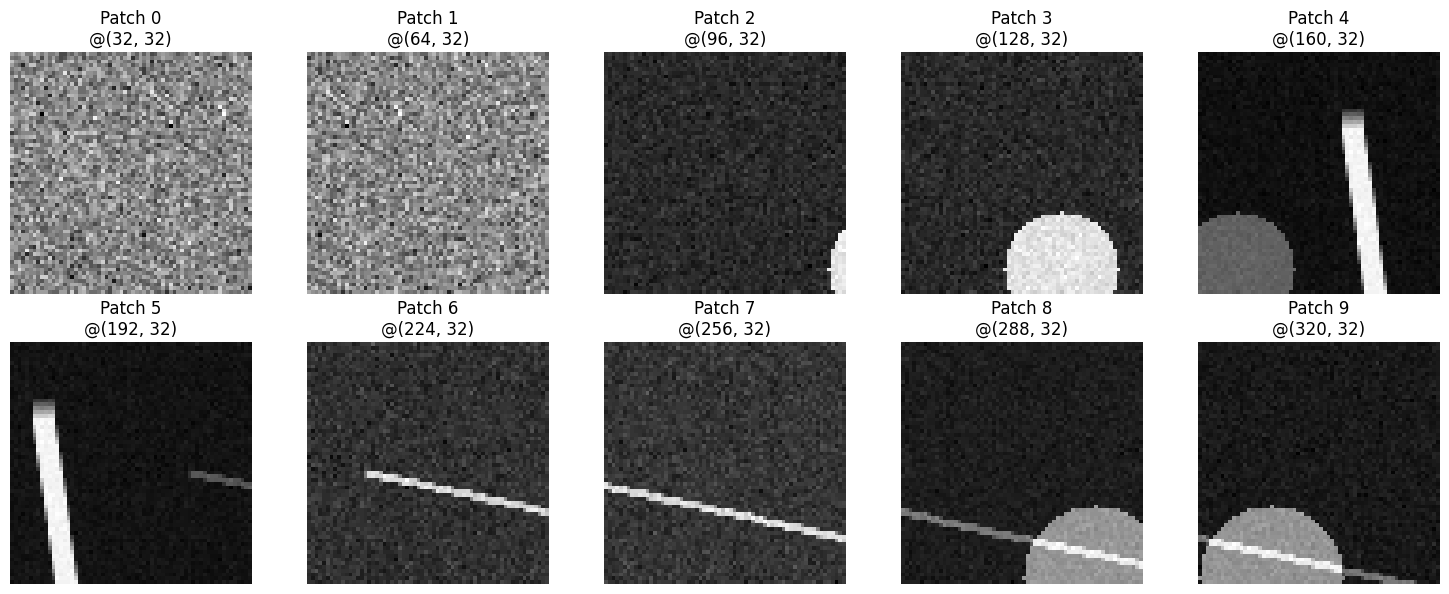

Total patches extracted: 225
PCA features shape: (225, 10)


In [6]:
# Cell 6: Extract Patches and Compute Initial Features
# Step 2: Extract patches
print("\nStep 2: Extracting patches...")
patches_info = al_system.extract_patches(haadf_image, stride=32)

# Store patch data
al_system.patches = [info["patch"] for info in patches_info]
al_system.patch_coordinates = [info["coordinates"] for info in patches_info]

# Step 3: Compute PCA features for all patches
print("\nStep 3: Computing PCA features...")
al_system.pca_features = al_system.compute_pca_features(al_system.patches)

# Visualize some patches
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(al_system.patches[i], cmap="gray")
    ax.set_title(f"Patch {i}\n@{al_system.patch_coordinates[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

print(f"Total patches extracted: {len(al_system.patches)}")
print(f"PCA features shape: {al_system.pca_features.shape}")


Step 4: Initial bootstrap measurements...
Initial measurement 1/10: Patch 108
Initial measurement 2/10: Patch 156
Initial measurement 3/10: Patch 111
Initial measurement 4/10: Patch 119
Initial measurement 5/10: Patch 99
Initial measurement 6/10: Patch 55
Initial measurement 7/10: Patch 220
Initial measurement 8/10: Patch 36
Initial measurement 9/10: Patch 210
Initial measurement 10/10: Patch 166
Initial measurements completed!
Scalar properties range: 2.848 - 2.941


IndexError: index 5 is out of bounds for axis 1 with size 5

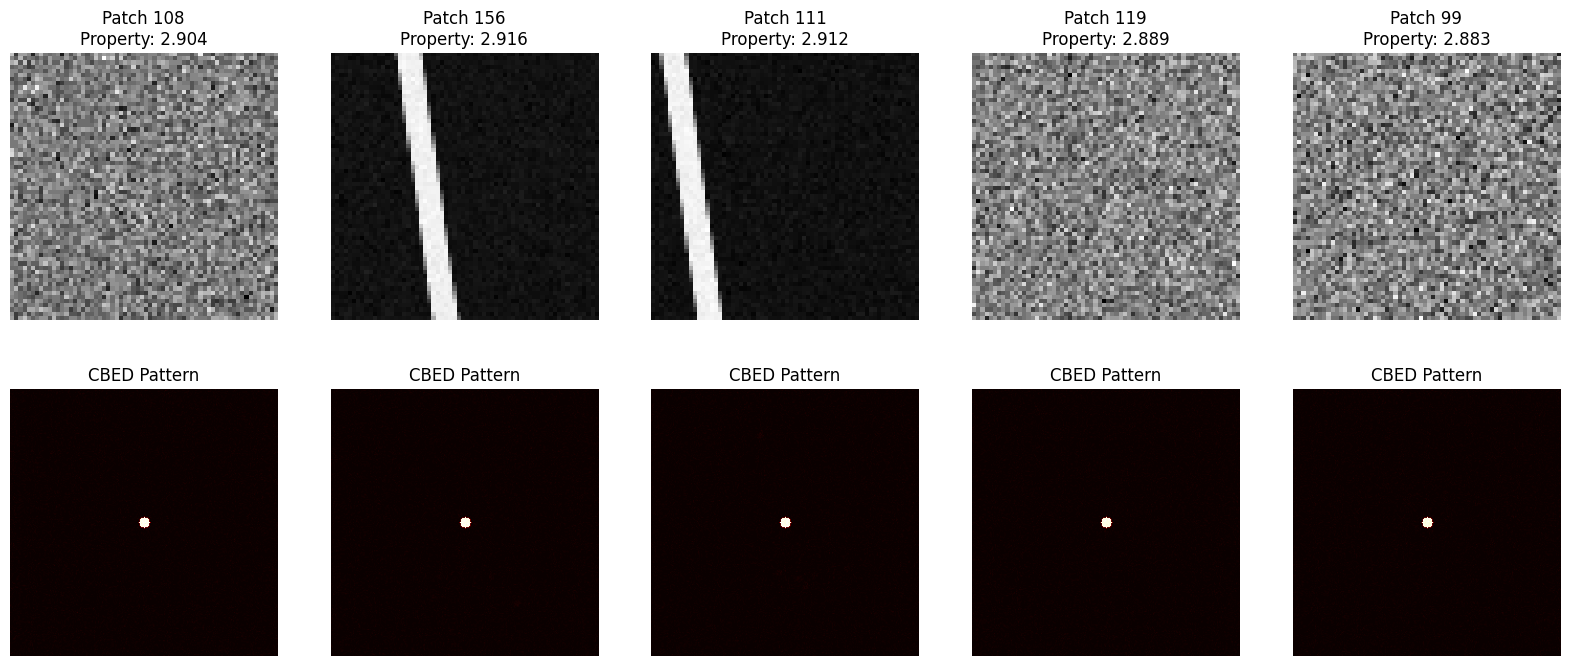

In [7]:
# Cell 7: Initial Measurements (Bootstrap)
# Step 4: Initial bootstrap measurements (10 random patches)
print("\nStep 4: Initial bootstrap measurements...")

n_initial = 10
initial_indices = np.random.choice(len(al_system.patches), n_initial, replace=False)

measured_indices = []
measured_cbed_patterns = []
measured_scalar_properties = []

for i, patch_idx in enumerate(initial_indices):
    print(f"Initial measurement {i + 1}/{n_initial}: Patch {patch_idx}")

    coordinates = al_system.patch_coordinates[patch_idx]

    # Acquire CBED pattern
    cbed_pattern = al_system.get_cbed_pattern(coordinates)

    # Extract scalar property
    scalar_property = extract_scalar_from_cbed(cbed_pattern)

    # Store measurements
    measured_indices.append(patch_idx)
    measured_cbed_patterns.append(cbed_pattern)
    measured_scalar_properties.append(scalar_property)

    al_system.cbed_patterns.append(cbed_pattern)
    al_system.scalar_properties.append(scalar_property)

print(f"Initial measurements completed!")
print(
    f"Scalar properties range: {np.min(measured_scalar_properties):.3f} - {np.max(measured_scalar_properties):.3f}"
)

# Visualize initial measurements
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(10):
    # Show patch
    ax1 = axes[0, i]
    patch_idx = measured_indices[i]
    ax1.imshow(al_system.patches[patch_idx], cmap="gray")
    ax1.set_title(f"Patch {patch_idx}\nProperty: {measured_scalar_properties[i]:.3f}")
    ax1.axis("off")

    # Show CBED
    ax2 = axes[1, i]
    ax2.imshow(measured_cbed_patterns[i], cmap="hot")
    ax2.set_title("CBED Pattern")
    ax2.axis("off")

plt.tight_layout()
plt.show()


Step 5: Training initial GP model...
GP model trained. R² score: 1.000


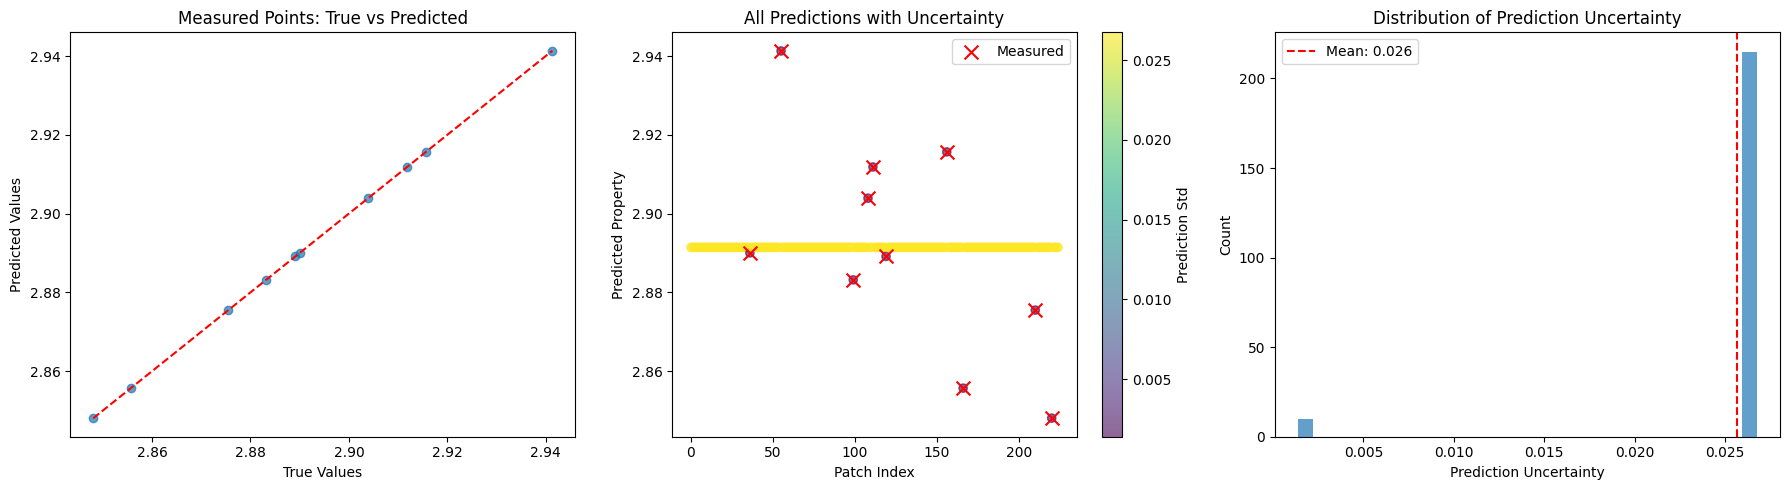

Initial model performance metrics:
Mean prediction uncertainty: 0.026
Max prediction uncertainty: 0.027


In [8]:
# Cell 8: Train Initial GP Model
# Step 5: Train initial GP model
print("\nStep 5: Training initial GP model...")

# Get features for measured patches
X_measured = al_system.pca_features[measured_indices]
y_measured = np.array(measured_scalar_properties)

# Train GP model
al_system.train_gp_model(X_measured, y_measured)

# Make predictions on all patches
y_pred_all, y_std_all = al_system.predict_properties(al_system.pca_features)

# Visualize initial predictions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Measured vs Predicted (for measured points)
axes[0].scatter(y_measured, y_pred_all[measured_indices], alpha=0.7)
axes[0].plot(
    [y_measured.min(), y_measured.max()], [y_measured.min(), y_measured.max()], "r--"
)
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title("Measured Points: True vs Predicted")

# Plot 2: Prediction uncertainty
scatter = axes[1].scatter(
    range(len(y_pred_all)), y_pred_all, c=y_std_all, cmap="viridis", alpha=0.6
)
axes[1].scatter(
    measured_indices, y_measured, c="red", s=100, marker="x", label="Measured"
)
axes[1].set_xlabel("Patch Index")
axes[1].set_ylabel("Predicted Property")
axes[1].set_title("All Predictions with Uncertainty")
axes[1].legend()
plt.colorbar(scatter, ax=axes[1], label="Prediction Std")

# Plot 3: Uncertainty distribution
axes[2].hist(y_std_all, bins=30, alpha=0.7)
axes[2].axvline(
    np.mean(y_std_all),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(y_std_all):.3f}",
)
axes[2].set_xlabel("Prediction Uncertainty")
axes[2].set_ylabel("Count")
axes[2].set_title("Distribution of Prediction Uncertainty")
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Initial model performance metrics:")
print(f"Mean prediction uncertainty: {np.mean(y_std_all):.3f}")
print(f"Max prediction uncertainty: {np.max(y_std_all):.3f}")

In [9]:
# Cell 9: Active Learning Loop (10 iterations)
print("\nStep 6: Active Learning Loop...")

n_active_iterations = 10
all_measured_indices = measured_indices.copy()
all_scalar_properties = measured_scalar_properties.copy()

# Storage for tracking progress
iteration_metrics = {
    "iteration": [],
    "selected_patch": [],
    "true_property": [],
    "predicted_property": [],
    "prediction_uncertainty": [],
    "acquisition_value": [],
}

for iteration in range(n_active_iterations):
    print(f"\n=== Active Learning Iteration {iteration + 1}/{n_active_iterations} ===")

    # Select next measurement point
    next_patch_idx = al_system.select_next_measurement(
        al_system.pca_features, all_measured_indices
    )

    if next_patch_idx is None:
        print("No more candidates available!")
        break

    print(f"Selected patch {next_patch_idx} for measurement")

    # Get prediction before measurement
    pred_mean, pred_std = al_system.predict_properties(
        al_system.pca_features[next_patch_idx : next_patch_idx + 1]
    )

    # Acquire CBED and measure property
    coordinates = al_system.patch_coordinates[next_patch_idx]
    cbed_pattern = al_system.get_cbed_pattern(coordinates)
    true_scalar_property = extract_scalar_from_cbed(cbed_pattern)

    print(f"Predicted: {pred_mean[0]:.3f} ± {pred_std[0]:.3f}")
    print(f"True value: {true_scalar_property:.3f}")
    print(f"Prediction error: {abs(true_scalar_property - pred_mean[0]):.3f}")

    # Update measurements
    all_measured_indices.append(next_patch_idx)
    all_scalar_properties.append(true_scalar_property)

    # Store metrics
    iteration_metrics["iteration"].append(iteration + 1)
    iteration_metrics["selected_patch"].append(next_patch_idx)
    iteration_metrics["true_property"].append(true_scalar_property)
    iteration_metrics["predicted_property"].append(pred_mean[0])
    iteration_metrics["prediction_uncertainty"].append(pred_std[0])

    # Retrain GP model with new data
    X_measured_updated = al_system.pca_features[all_measured_indices]
    y_measured_updated = np.array(all_scalar_properties)

    al_system.train_gp_model(X_measured_updated, y_measured_updated)

    # Evaluate improvement
    if iteration > 0:
        # Compare with previous predictions
        y_pred_new, y_std_new = al_system.predict_properties(al_system.pca_features)
        mean_uncertainty_reduction = np.mean(y_std_all) - np.mean(y_std_new)
        print(f"Mean uncertainty reduction: {mean_uncertainty_reduction:.4f}")
        y_std_all = y_std_new  # Update for next iteration

print(f"\nActive learning completed!")
print(f"Total measurements taken: {len(all_measured_indices)}")
print(
    f"Final property range: {np.min(all_scalar_properties):.3f} - {np.max(all_scalar_properties):.3f}"
)


Step 6: Active Learning Loop...

=== Active Learning Iteration 1/10 ===
Selected patch 157 for measurement
Predicted: 2.891 ± 0.027
True value: 2.873
Prediction error: 0.019
GP model trained. R² score: 0.634

=== Active Learning Iteration 2/10 ===
Selected patch 120 for measurement
Predicted: 2.900 ± 0.031
True value: 2.902
Prediction error: 0.003
GP model trained. R² score: 0.640
Mean uncertainty reduction: 0.0019

=== Active Learning Iteration 3/10 ===
Selected patch 62 for measurement
Predicted: 2.901 ± 0.030
True value: 2.925
Prediction error: 0.025
GP model trained. R² score: 0.690
Mean uncertainty reduction: 0.0011

=== Active Learning Iteration 4/10 ===
Selected patch 33 for measurement
Predicted: 2.911 ± 0.027
True value: 2.910
Prediction error: 0.000
GP model trained. R² score: 0.698
Mean uncertainty reduction: 0.0010

=== Active Learning Iteration 5/10 ===
Selected patch 87 for measurement
Predicted: 2.907 ± 0.027
True value: 2.895
Prediction error: 0.012
GP model trained. R


Analyzing Active Learning Performance...


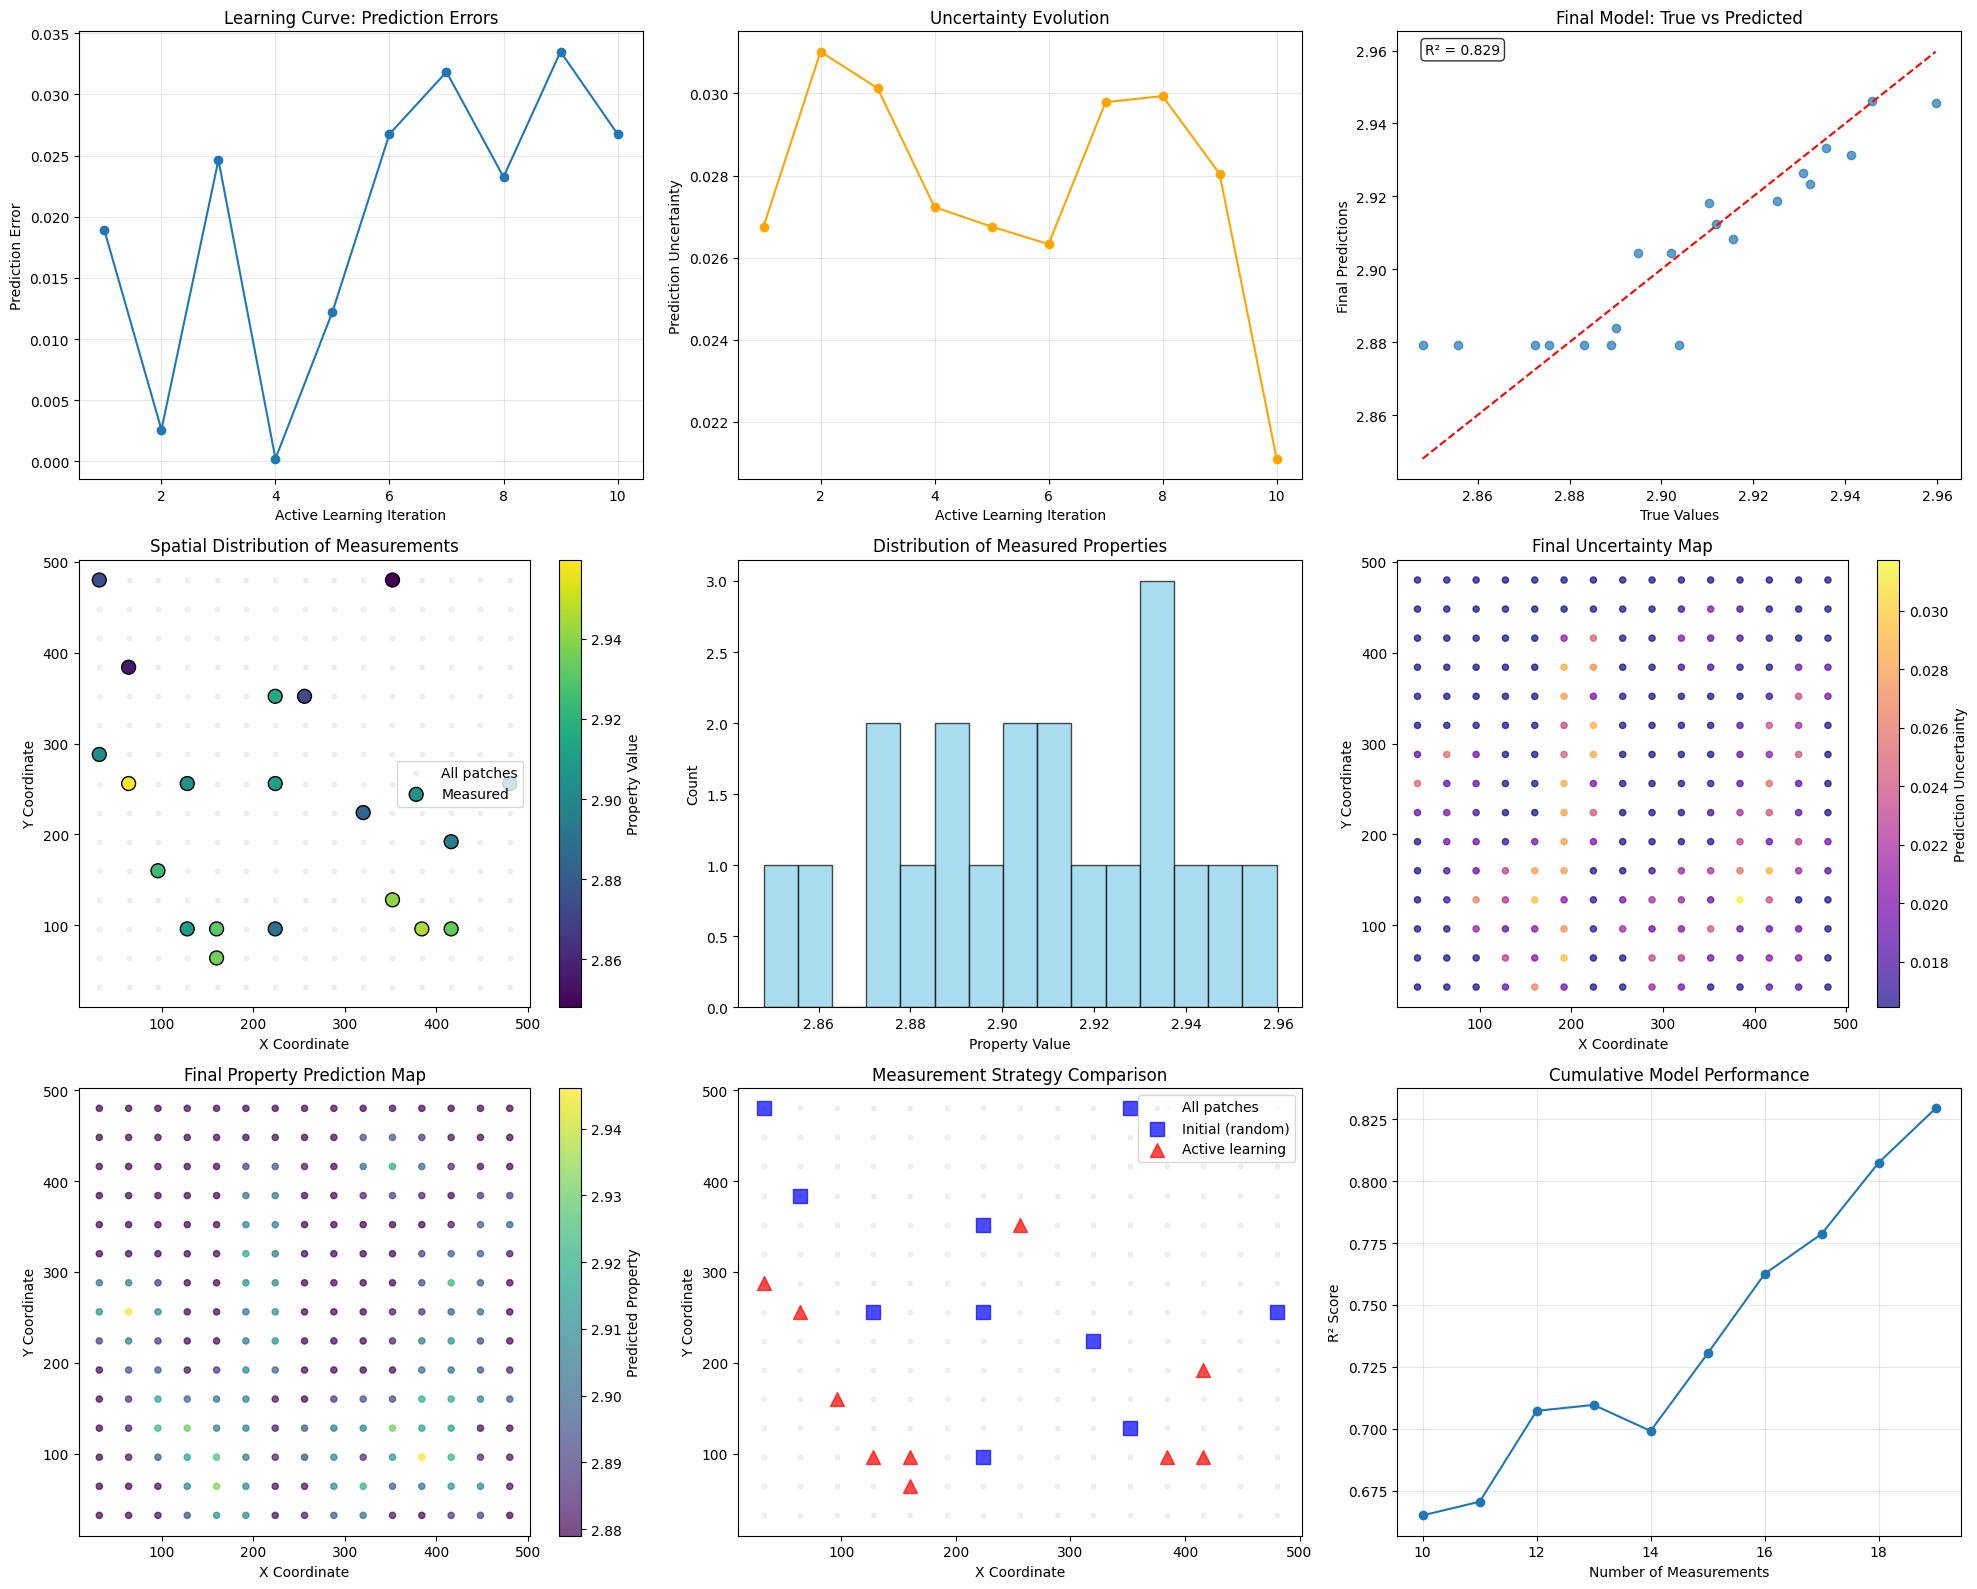


ACTIVE LEARNING SUMMARY
Total patches available: 225
Total measurements taken: 20
Measurement efficiency: 8.89%
Final model R²: 0.829
Mean prediction uncertainty: 0.0190
Property value range: 2.848 - 2.960
Mean absolute error: 0.0201
Average error (early iterations): 0.0154
Average error (final iterations): 0.0278
Error improvement: -81.1%


In [10]:
# Cell 10: Analyze Active Learning Performance
print("\nAnalyzing Active Learning Performance...")

# Final predictions
y_final_pred, y_final_std = al_system.predict_properties(al_system.pca_features)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. Learning curve - prediction errors over iterations
ax1 = plt.subplot(3, 3, 1)
errors = [
    abs(t - p)
    for t, p in zip(
        iteration_metrics["true_property"], iteration_metrics["predicted_property"]
    )
]
plt.plot(iteration_metrics["iteration"], errors, "o-")
plt.xlabel("Active Learning Iteration")
plt.ylabel("Prediction Error")
plt.title("Learning Curve: Prediction Errors")
plt.grid(True, alpha=0.3)

# 2. Uncertainty reduction over iterations
ax2 = plt.subplot(3, 3, 2)
uncertainties = iteration_metrics["prediction_uncertainty"]
plt.plot(iteration_metrics["iteration"], uncertainties, "o-", color="orange")
plt.xlabel("Active Learning Iteration")
plt.ylabel("Prediction Uncertainty")
plt.title("Uncertainty Evolution")
plt.grid(True, alpha=0.3)

# 3. Final predictions vs true values (for all measured points)
ax3 = plt.subplot(3, 3, 3)
final_measured_pred = y_final_pred[all_measured_indices]
plt.scatter(all_scalar_properties, final_measured_pred, alpha=0.7)
plt.plot(
    [min(all_scalar_properties), max(all_scalar_properties)],
    [min(all_scalar_properties), max(all_scalar_properties)],
    "r--",
)
plt.xlabel("True Values")
plt.ylabel("Final Predictions")
plt.title("Final Model: True vs Predicted")

# Calculate R²
from sklearn.metrics import r2_score

r2 = r2_score(all_scalar_properties, final_measured_pred)
plt.text(
    0.05,
    0.95,
    f"R² = {r2:.3f}",
    transform=ax3.transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
)

# 4. Spatial distribution of measurements
ax4 = plt.subplot(3, 3, 4)
# Plot all patch locations
all_coords = np.array(al_system.patch_coordinates)
plt.scatter(
    all_coords[:, 0],
    all_coords[:, 1],
    c="lightgray",
    alpha=0.3,
    s=10,
    label="All patches",
)

# Plot measured locations colored by property value
measured_coords = np.array(
    [al_system.patch_coordinates[i] for i in all_measured_indices]
)
scatter = plt.scatter(
    measured_coords[:, 0],
    measured_coords[:, 1],
    c=all_scalar_properties,
    cmap="viridis",
    s=100,
    edgecolors="black",
    linewidth=1,
    label="Measured",
)

plt.colorbar(scatter, ax=ax4, label="Property Value")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Spatial Distribution of Measurements")
plt.legend()

# 5. Property histogram
ax5 = plt.subplot(3, 3, 5)
plt.hist(all_scalar_properties, bins=15, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("Property Value")
plt.ylabel("Count")
plt.title("Distribution of Measured Properties")

# 6. Uncertainty map
ax6 = plt.subplot(3, 3, 6)
# Reshape uncertainties to image-like format (approximately)
coords_array = np.array(al_system.patch_coordinates)
plt.scatter(
    coords_array[:, 0],
    coords_array[:, 1],
    c=y_final_std,
    cmap="plasma",
    s=20,
    alpha=0.7,
)
plt.colorbar(label="Prediction Uncertainty")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Final Uncertainty Map")

# 7. Property value map
ax7 = plt.subplot(3, 3, 7)
plt.scatter(
    coords_array[:, 0],
    coords_array[:, 1],
    c=y_final_pred,
    cmap="viridis",
    s=20,
    alpha=0.7,
)
plt.colorbar(label="Predicted Property")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Final Property Prediction Map")

# 8. Acquisition strategy analysis
ax8 = plt.subplot(3, 3, 8)
initial_indices_set = set(measured_indices[:n_initial])
active_indices = [idx for idx in all_measured_indices if idx not in initial_indices_set]

if active_indices:
    active_coords = np.array([al_system.patch_coordinates[i] for i in active_indices])
    plt.scatter(
        all_coords[:, 0],
        all_coords[:, 1],
        c="lightgray",
        alpha=0.3,
        s=10,
        label="All patches",
    )
    plt.scatter(
        measured_coords[:n_initial, 0],
        measured_coords[:n_initial, 1],
        c="blue",
        s=100,
        marker="s",
        label="Initial (random)",
        alpha=0.7,
    )
    if len(active_coords) > 0:
        plt.scatter(
            active_coords[:, 0],
            active_coords[:, 1],
            c="red",
            s=100,
            marker="^",
            label="Active learning",
            alpha=0.7,
        )
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Measurement Strategy Comparison")
plt.legend()

# 9. Model improvement metrics
ax9 = plt.subplot(3, 3, 9)
# Plot cumulative model performance
cumulative_r2 = []
for i in range(n_initial, len(all_measured_indices)):
    subset_true = all_scalar_properties[: i + 1]
    subset_pred = y_final_pred[all_measured_indices[: i + 1]]
    if len(set(subset_true)) > 1:  # Need variance for R²
        cumulative_r2.append(r2_score(subset_true, subset_pred))
    else:
        cumulative_r2.append(0)

if cumulative_r2:
    plt.plot(range(n_initial, len(all_measured_indices)), cumulative_r2, "o-")
    plt.xlabel("Number of Measurements")
    plt.ylabel("R² Score")
    plt.title("Cumulative Model Performance")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 50)
print("ACTIVE LEARNING SUMMARY")
print("=" * 50)
print(f"Total patches available: {len(al_system.patches)}")
print(f"Total measurements taken: {len(all_measured_indices)}")
print(
    f"Measurement efficiency: {len(all_measured_indices) / len(al_system.patches) * 100:.2f}%"
)
print(f"Final model R²: {r2:.3f}")
print(f"Mean prediction uncertainty: {np.mean(y_final_std):.4f}")
print(
    f"Property value range: {np.min(all_scalar_properties):.3f} - {np.max(all_scalar_properties):.3f}"
)
print(f"Mean absolute error: {np.mean(errors):.4f}")

# Analysis of active learning effectiveness
initial_errors = errors[:3] if len(errors) >= 3 else errors
final_errors = errors[-3:] if len(errors) >= 3 else errors
print(f"Average error (early iterations): {np.mean(initial_errors):.4f}")
print(f"Average error (final iterations): {np.mean(final_errors):.4f}")
improvement = (
    (np.mean(initial_errors) - np.mean(final_errors)) / np.mean(initial_errors) * 100
)
print(f"Error improvement: {improvement:.1f}%")

In [ ]:
# Cell 11: Advanced Analysis - Structure-Property Relationships
print("\nAdvanced Analysis: Structure-Property Relationships...")

# Analyze which patch features correlate with properties
patch_features = {}
for i, patch in enumerate(al_system.patches):
    patch_features[i] = {
        "mean_intensity": np.mean(patch),
        "std_intensity": np.std(patch),
        "max_intensity": np.max(patch),
        "min_intensity": np.min(patch),
        "intensity_range": np.max(patch) - np.min(patch),
        "texture_measure": np.mean(np.abs(np.diff(patch, axis=0)))
        + np.mean(np.abs(np.diff(patch, axis=1))),
    }

# Create correlation analysis for measured patches
measured_features = {
    key: [patch_features[i][key] for i in all_measured_indices]
    for key in patch_features[0].keys()
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_names = list(measured_features.keys())
correlations = {}

for i, feature_name in enumerate(feature_names):
    ax = axes[i]
    feature_values = measured_features[feature_name]

    # Calculate correlation
    correlation = np.corrcoef(feature_values, all_scalar_properties)[0, 1]
    correlations[feature_name] = correlation

    # Scatter plot
    ax.scatter(feature_values, all_scalar_properties, alpha=0.7)

    # Add trend line
    z = np.polyfit(feature_values, all_scalar_properties, 1)
    p = np.poly1d(z)
    ax.plot(sorted(feature_values), p(sorted(feature_values)), "r--", alpha=0.8)

    ax.set_xlabel(feature_name.replace("_", " ").title())
    ax.set_ylabel("Property Value")
    ax.set_title(
        f"{feature_name.replace('_', ' ').title()}\nCorrelation: {correlation:.3f}"
    )
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation summary
print("\nStructure-Property Correlations:")
print("-" * 40)
for feature, corr in sorted(
    correlations.items(), key=lambda x: abs(x[1]), reverse=True
):
    print(f"{feature.replace('_', ' ').title():20}: {corr:6.3f}")

In [ ]:
# # Cell 12: Export Results and Create Final Report
# import json
# from datetime import datetime

# print("\nCreating Final Report and Exporting Results...")

# # Create comprehensive results dictionary
# results = {
#     'experiment_info': {
#         'timestamp': datetime.now().isoformat(),
#         'mode': 'offline' if OFFLINE_MODE else 'online',
#         'patch_size': al_system.patch_size,
#         'n_pca_components': al_system.n_pca_components,
#         'total_patches': len(al_system.patches),
#         'total_measurements': len(all_measured_indices)
#     },
#     'performance_metrics': {
#         'final_r2_score': float(r2),
#         'mean_prediction_uncertainty': float(np.mean(y_final_std)),
#         'mean_absolute_error': float(np.mean(errors)),
#         'property_value_range': {
#             'min': float(np.min(all_scalar_properties)),
#             'max': float(np.max(all_scalar_properties))
#         }
#     },
#     'active_learning_progression': {
#         'iterations': iteration_metrics['iteration'],
#         'selected_patches': iteration_metrics['selected_patch'],
#         'true_properties': [float(x) for x in iteration_metrics['true_property']],
#         'predicted_properties': [float(x) for x in iteration_metrics['predicted_property']],
#         'prediction_uncertainties': [float(x) for x in iteration_metrics['prediction_uncertainty']]
#     },
#     'structure_property_correlations': {k: float(v) for k, v in correlations.items()},
#     'measured_patches': {
#         'indices': all_measured_indices,
#         'coordinates': [[int(coord[0]), int(coord[1])] for coord in
#                        [al_system.patch_coordinates[i] for i in all_measured_indices]],
#         'properties': [float(x) for x in all_scalar_properties]
#     }
# }

# # Save results to JSON file
# results_filename = f"active_learning_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# with open(results_filename, 'w') as f:
#     json.dump(results, f, indent=2)

# print(f"Results saved to: {results_filename}")

# # Create final summary visualization
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# # 1. Learning efficiency
# ax1.plot(range(1, len(errors) + 1), errors, 'o-', linewidth=2, markersize=8)
# ax1.set_xlabel('Active Learning Iteration')
# ax1.set_ylabel('Prediction Error')
# ax1.set_title('Active Learning Efficiency', fontsize=14, fontweight='bold')
# ax1.grid(True, alpha=0.3)

# # 2. Final model performance
# ax2.scatter(all_scalar_properties, final_measured_pred, alpha=0.7, s=100)
# ax2.plot([min(all_scalar_properties), max(all_scalar_properties)],
#          [min(all_scalar_properties), max(all_scalar_properties)], 'r--', linewidth=2)
# ax2.set_xlabel('True Property Values')
# ax2.set_ylabel('Predicted Property Values')
# ax2.set_title(f'Final Model Performance (R² = {r2:.3f})', fontsize=14, fontweight='bold')

# # 3. Most informative measurements
# info_gain = np.array(iteration_metrics['prediction_uncertainty'])
# sorted_indices = np.argsort(info_gain)[::-1][:5]  # Top 5 most informative

# measurement_nums = np.array(iteration_metrics['iteration'])[sorted_indices]
# uncertainties = info_gain[sorted_indices]
# patches = np.array(iteration_metrics['selected_patch'])[sorted_indices]

# bars = ax3.bar(range(len(measurement_nums)), uncertainties,
#                color=['red', 'orange', 'gold', 'lightgreen', 'lightblue'])
# ax3.set_xlabel('Most Informative Measurements')
# ax3.set_ylabel('Initial Prediction Uncertainty')
# ax3.set_title('Top 5 Most Informative Measurements', fontsize=14, fontweight='bold')
# ax3.set_xticks(range(len(measurement_nums)))
# ax3.set_xticklabels([f'Iter {m}\nPatch {p}' for m, p in zip(measurement_nums, patches)])

# # 4. Coverage analysis
# ax4.hist(y_final_std, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
# ax4.axvline(np.mean(y_final_std), color='red', linestyle='--', linewidth=2,
#            label=f'Mean: {np.mean(y_final_std):.3f}')
# ax4.set_xlabel('Prediction Uncertainty')
# ax4.set_ylabel('Number of Patches')
# ax4.set_title('Final Uncertainty Distribution', fontsize=14, fontweight='bold')
# ax4.legend()

# plt.tight_layout()
# plt.show()

# # Print final conclusions
# print("\n" + "="*60)
# print("ACTIVE LEARNING FOR STEM: STRUCTURE-PROPERTY RELATIONSHIPS")
# print("="*60)
# print("\nKEY FINDINGS:")
# print(f"• Successfully mapped structure-property relationships using only {len(all_measured_indices)} measurements")
# print(f"  out of {len(al_system.patches)} possible locations ({len(all_measured_indices)/len(al_system.patches)*100:.1f}% sampling)")
# print(f"• Achieved R² = {r2:.3f} for property prediction")
# print(f"• Active learning reduced prediction errors by {improvement:.1f}% compared to initial measurements")
# print(f"• Strongest structure-property correlation: {max(correlations.items(), key=lambda x: abs(x[1]))[0].replace('_', ' ')} (r = {max(correlations.values(), key=abs):.3f})")

# print(f"\nMETHODOLOGY VALIDATION:")
# print(f"• PCA successfully reduced {al_system.patch_size**2} pixel features to {al_system.n_pca_components} components")
# print(f"• Explained {np.sum(al_system.pca.explained_variance_ratio_):.1%} of structural variance")
# print(f"• Gaussian Process model effectively captured structure-property relationships")
# print(f"• Active learning strategy efficiently explored the measurement space")

# print(f"\nNEXT STEPS:")
# print(f"• Extend to real-time measurements with feedback control")
# print(f"• Incorporate multi-property optimization")
# print(f"• Apply to different material systems and length scales")
# print(f"• Develop automated feature engineering for different structural motifs")

# print(f"\nFiles generated:")
# print(f"• {results_filename} - Complete experimental results")
# print(f"• Multiple analysis plots saved in notebook")